In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.optimize import curve_fit
from tqdm import tqdm
from cv2 import cv2

from hydramuscle.model.smc import SMC
from hydramuscle.model.layer import Layer

In [4]:
numx = 30
numy = 60
x0 = numx // 2
y0 = numy // 2
t0 = 0

In [5]:
T = 50
dt = 0.01
save_interval=10
smc = SMC(T=T, dt=dt, k_ipr=0.2, s0=100, k_deg=0.01)

active_v_beta_list = np.arange(.1, 1.1, .1)
calcium_data_list = []
for a_v_beta in active_v_beta_list:
    layer = Layer(smc, 
                  numx=numx, 
                  numy=numy, 
                  gip3x=0.1, 
                  gip3y=2.0, 
                  gcx=1000, 
                  gcy=1000,
                  save_interval=save_interval, 
                  active_v_beta=a_v_beta)

    layer.set_stim_pattern(pathway='slow',
                           xmin=14, xmax=16, ymin=29, ymax=31,
                           stim_times=[0])

    sol = layer.run(save_all=True)
    
    # Extract calcium data
    calcium = sol[:, :numx * numy].reshape(-1, numx, numy)
    calcium_data_list.append(calcium)

100%|██████████| 5000/5000 [00:01<00:00, 2824.72it/s]


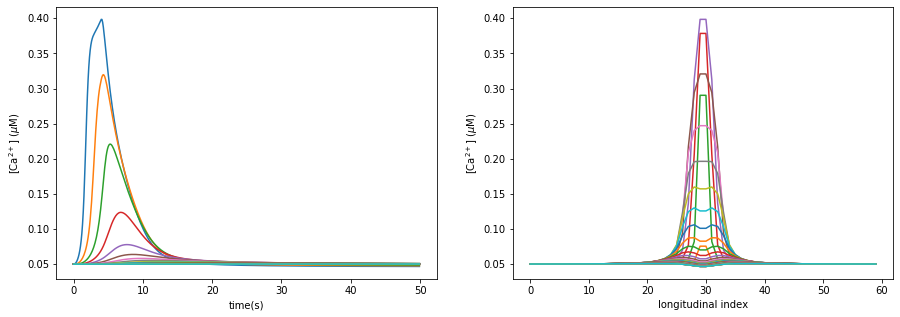

In [6]:
# Plot select data 

index = 0
calcium = calcium_data_list[index]

fig = plt.figure(figsize=(15,5))
# Calcium waves
ax11 = fig.add_subplot(121)
ax11.plot(np.arange(0, 50, dt*save_interval), calcium[:, numx // 2 , numy // 2 : ])
ax11.set_xlabel('time(s)')
ax11.set_ylabel(r'[Ca$^{2+}$] ($\mu$M)')
# Calcium wavefronts
ax12 = fig.add_subplot(122)
ax12.plot(calcium[:500, numx//2, :].T[:, ::10])
ax12.set_xlabel('longitudinal index')
ax12.set_ylabel(r'[Ca$^{2+}$] ($\mu$M)')
plt.show()

## Fitting

### 1. Fitting $\tau_\text{inc}$ and $\tau_\text{dec}$

In [7]:
select_index = 3

In [8]:
def calc_time_scales(arr, dt):

    ind_max = np.argmax(arr)
    time_inc = ind_max * dt
    time_dec = np.inf

    for index, v in enumerate(arr):
        if index > ind_max and v < max(arr) / np.e:
            time_dec = (index - ind_max) * dt
            break
            
    return time_inc, time_dec

def gf_select(tau_inc, tau_dec, t):
    return (1 - np.exp(- t / tau_inc)) * np.exp(- t / tau_dec)

def loss(t_inc, t_dec, time_inc, time_dec):
    return (t_inc / time_inc - 1) ** 2 + (t_dec / time_dec - 1) ** 2

In [9]:
tau_inc_best_list = []
tau_dec_best_list = []

for i in tqdm(range(len(calcium_data_list))):
    calcium = calcium_data_list[i]
    # Select trace
    select_trace = calcium[:, numx // 2, numy // 2 + select_index]
    # Cut off the initiating piece
    ind_init = np.argmax(select_trace > 0.055)
    select_trace = select_trace[ind_init:]
    # Subtract the resting value
    select_trace_subtracted = select_trace - 0.05
    # Extract time scales
    time_inc, time_dec = calc_time_scales(select_trace_subtracted, dt=dt * save_interval)
    # Sweep parameters to fit
    tau_inc_best = None
    tau_dec_best = None
    t_inc_best = None
    t_dec_best = None
    loss_best = np.inf
    for tau_inc in np.arange(0.1, 20.1, 0.1):
        for tau_dec in np.arange(0.1, 20.1, 0.1):
            sim_trace = []
            for t in np.arange(0, 50, 0.1):
                sim_trace.append(gf_select(tau_inc, tau_dec, t))
            t_inc, t_dec = calc_time_scales(sim_trace, 0.1)
            loss_tmp = loss(t_inc, t_dec, time_inc, time_dec)

            if loss_tmp < loss_best:
                loss_best = loss_tmp
                tau_inc_best, tau_dec_best = tau_inc, tau_dec
                t_inc_best, t_dec_best = t_inc, t_dec
                
    tau_inc_best_list.append(tau_inc_best)
    tau_dec_best_list.append(tau_dec_best)
    
    print(time_inc, time_dec)
    print(t_inc_best, t_dec_best)
    print('---------------------')

 10%|█         | 1/10 [02:00<18:04, 120.50s/it]

4.2 4.6000000000000005
2.6 5.5
---------------------


 20%|██        | 2/10 [03:56<15:52, 119.04s/it]

3.3000000000000003 6.800000000000001
3.3000000000000003 7.0
---------------------


 30%|███       | 3/10 [05:50<13:44, 117.72s/it]

3.4000000000000004 8.0
3.4000000000000004 8.0
---------------------


 40%|████      | 4/10 [07:45<11:40, 116.75s/it]

3.5 8.5
3.5 8.5
---------------------


 50%|█████     | 5/10 [09:40<09:41, 116.22s/it]

3.6 8.6
3.6 8.6
---------------------


 60%|██████    | 6/10 [11:33<07:41, 115.38s/it]

3.6 8.700000000000001
3.6 8.700000000000001
---------------------


 70%|███████   | 7/10 [13:26<05:43, 114.62s/it]

3.6 8.8
3.6 8.8
---------------------


 80%|████████  | 8/10 [15:19<03:48, 114.15s/it]

3.6 8.700000000000001
3.6 8.700000000000001
---------------------


 90%|█████████ | 9/10 [17:12<01:53, 113.79s/it]

3.6 8.8
3.6 8.8
---------------------


100%|██████████| 10/10 [19:05<00:00, 114.53s/it]

3.5 8.8
3.5 8.8
---------------------


In [10]:
print([round(x, 2) for x in tau_inc_best_list])
print([round(x, 2) for x in tau_dec_best_list])

[10.2, 12.8, 3.8, 3.4, 3.8, 3.6, 3.5, 3.6, 3.5, 3.1]
[2.9, 3.7, 5.4, 6.0, 5.9, 6.1, 6.2, 6.1, 6.2, 6.4]


### 2. Fitting $amp$

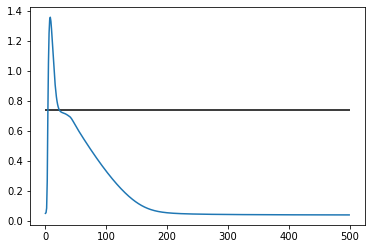

In [11]:
# Ignore the absurd peak
plt.figure()
plt.plot(calcium_data_list[9][:, numx // 2,  numy // 2])
plt.hlines(0.74, 0, 500)
plt.show()

In [12]:
# Assign maximum values manually
amp_max_appt_list = [0.398, 0.551, 0.62, 0.66, 0.68, 0.7, 0.71, 0.72, 0.73, 0.74]
amp_max_appt_list = [x - 0.05 for x in amp_max_appt_list]

In [13]:
amp_best_list = []

for i in range(len(calcium_data_list)):
    calcium = calcium_data_list[i]
    sim_trace = []
    for t in np.arange(0, 50, 0.1):
        sim_trace.append(gf_select(tau_inc_best_list[i], tau_dec_best_list[i], t))
#     first_trace = calcium[:, numx // 2, numy // 2]
    amp_best = amp_max_appt_list[i] / max(sim_trace) 
    amp_best_list.append(amp_best)

### 3. Fitting $v, \rho_e, c_x$ 

In [14]:
def calc_diffs(last_trace, first_trace, dt, amp_metric='abs', real_curve=False, amp_m_appt=None):
    t_lag = np.argmax(last_trace) * dt - np.argmax(first_trace) * dt
    
    if real_curve:
        amp_max = amp_m_appt
    else:
        amp_max = max(first_trace)
    
    if amp_metric == 'abs':
        a_diff = amp_max - max(last_trace)
    elif amp_metric == 'ratio':
        a_diff = max(last_trace) / amp_max
    return t_lag, a_diff

def greens_function_2d(x, y, t, x0, y0, t0, tau_inc, tau_dec, amp, v, rho_e, c_x):
    t = t - t0
    rho = np.sqrt((c_x * (x - x0)) ** 2 + (y - y0) ** 2)
    if t <= rho / v:
        return 0.05
    else:
        return amp * (1 - np.exp(-(t - rho / v) / tau_inc)) * np.exp(-(t - rho / v) / tau_dec) * np.exp(-rho / rho_e) + 0.05
    
def loss2(t_lag, time_lag, a_diff, amp_diff):
    return (t_lag / time_lag - 1) ** 2 + (a_diff / amp_diff - 1) ** 2

In [15]:
rho_e_best_list = []
v_best_list = [] 
c_x_best_list = []

for i in tqdm(range(len(calcium_data_list))):
    calcium = calcium_data_list[i]
    # Select traces
    select_trace_1 = calcium[:, numx // 2, numy // 2]
    select_trace_2 = calcium[:, numx // 2, numy // 2 + 8]
    select_trace_2_x = calcium[:, numx // 2 + 2, numy // 2]
    # Calculate the real targets
    time_lag, amp_diff = calc_diffs(select_trace_2, select_trace_1, dt*save_interval, amp_metric='ratio', real_curve=True, amp_m_appt=amp_max_appt_list[i])
    time_lag_x, amp_diff_x = calc_diffs(select_trace_2_x, select_trace_1, dt*save_interval, amp_metric='ratio', real_curve=True, amp_m_appt=amp_max_appt_list[i])
    # Sweep parameters
    v_best = None
    rho_e_best = None
    t_lag_best = None
    a_diff_best = None
    t_lag_x_best = None
    a_diff_x_best = None
    c_x_best = None
    loss2_best = np.inf
    
    amp_best = amp_best_list[i]
    tau_inc_best = tau_inc_best_list[i]
    tau_dec_best = tau_dec_best_list[i]
    
    for v in np.arange(.2, 5, .2):
        for rho_e in np.arange(.5, 10, .5):
            for c_x in np.arange(.1, 10, .1):
                sim_last_trace = []
                sim_last_trace_x = []
                sim_first_trace = []

                for t in np.arange(0, 50, 0.1):
                    sim_first_trace.append(greens_function_2d(numx//2, numy//2, t, numx//2, numy//2, 0, tau_inc_best, tau_dec_best, amp_best, v, rho_e, c_x))
                    sim_last_trace.append(greens_function_2d(numx//2, numy//2 + 8, t, numx//2, numy//2, 0, tau_inc_best, tau_dec_best, amp_best, v, rho_e, c_x))
                    sim_last_trace_x.append(greens_function_2d(numx//2 + 2, numy//2, t, numx//2, numy//2, 0, tau_inc_best, tau_dec_best, amp_best, v, rho_e, c_x))

                t_lag, a_diff = calc_diffs(sim_last_trace, sim_first_trace, 0.1, amp_metric='ratio')
                t_lag_x, a_diff_x = calc_diffs(sim_last_trace_x, sim_first_trace, 0.1, amp_metric='ratio')
                loss2_tmp = loss2(t_lag, time_lag, a_diff, amp_diff) + loss2(t_lag_x, time_lag_x, a_diff_x, amp_diff_x)

                if loss2_tmp < loss2_best:
                    loss2_best = loss2_tmp
                    rho_e_best, v_best, c_x_best = rho_e, v, c_x
                    t_lag_best, a_diff_best = t_lag, a_diff
                    t_lag_x_best, a_diff_x_best = t_lag_x, a_diff_x
                
    rho_e_best_list.append(rho_e_best)
    v_best_list.append(v_best)
    c_x_best_list.append(c_x_best)
    print(t_lag_best, a_diff_best, t_lag_x_best, a_diff_x_best)
    print(time_lag, amp_diff, time_lag_x, amp_diff_x)
    print('params:', rho_e_best, v_best, c_x_best)
    print('---------------------')

 10%|█         | 1/10 [06:25<57:53, 385.92s/it]

8.000000000000002 0.16126946478510412 11.4 0.13477587063395105
8.5 0.15426551687304246 11.700000000000001 0.14879835991194845
params: 2.5 1.0 5.7
---------------------


 20%|██        | 2/10 [12:53<51:30, 386.28s/it]

8.0 0.12780737603114606 11.4 0.10025679043676375
8.8 0.12430481182216602 11.8 0.1093073028125066
params: 2.5 1.0 5.7
---------------------


 30%|███       | 3/10 [19:20<45:05, 386.57s/it]

10.0 0.14452510838225305 14.200000000000001 0.10121311035429445
12.0 0.14985798905010603 14.7 0.10464296990634886
params: 3.0 0.8 5.7
---------------------


 40%|████      | 4/10 [25:46<38:39, 386.60s/it]

10.0 0.2008401860217178 15.700000000000003 0.11536595504770199
11.700000000000001 0.23250107922934202 15.1 0.11160566426017358
params: 4.0 0.8 6.3
---------------------


 50%|█████     | 5/10 [32:10<32:08, 385.80s/it]

10.000000000000002 0.2898662968048168 17.2 0.14889433889732728
10.5 0.31016752693782246 15.400000000000002 0.1335657909594563
params: 5.5 0.8 6.9
---------------------


 60%|██████    | 6/10 [38:44<25:52, 388.22s/it]

10.000000000000002 0.342634407713456 16.7 0.18959958681555283
9.9 0.3614033268379884 15.200000000000001 0.17459074393114876
params: 6.5 0.8 6.7
---------------------


 70%|███████   | 7/10 [45:40<19:49, 396.50s/it]

10.000000000000002 0.3668708842729866 15.200000000000001 0.23312103270868426
9.6 0.40436403574541097 14.200000000000001 0.2241013569268523
params: 7.0 0.8 6.1
---------------------


 80%|████████  | 8/10 [52:14<13:11, 395.69s/it]

10.000000000000002 0.38969866277753656 14.000000000000002 0.2784683123655168
9.5 0.4395863904225014 13.2 0.26404169708482694
params: 7.5 0.8 5.6
---------------------


 90%|█████████ | 9/10 [58:42<06:33, 393.53s/it]

8.000000000000002 0.4514470651299828 12.6 0.29819991161683895
9.3 0.46931855496176605 12.5 0.29533459557103137
params: 9.0 1.0 6.3
---------------------


100%|██████████| 10/10 [1:05:18<00:00, 391.82s/it]

8.0 0.46926189795436524 12.200000000000001 0.3257292756412871
9.1 0.4946850199424508 12.1 0.32093563695096694
params: 9.5 1.0 6.1
---------------------


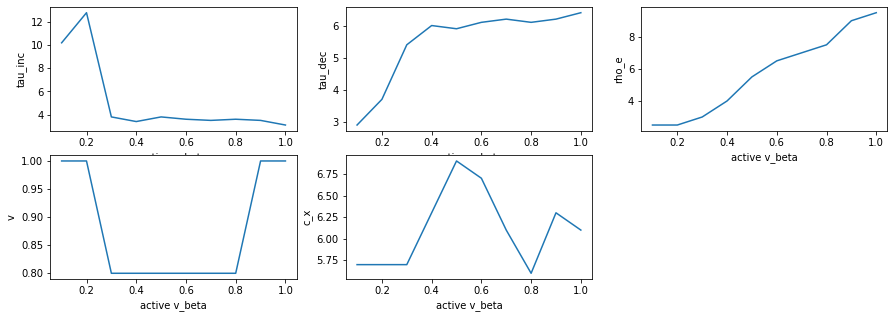

In [21]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(231)
ax.plot(active_v_beta_list, tau_inc_best_list)
ax.set_xlabel('active v_beta')
ax.set_ylabel('tau_inc')

ax = fig.add_subplot(232)
ax.plot(active_v_beta_list, tau_dec_best_list)
ax.set_xlabel('active v_beta')
ax.set_ylabel('tau_dec')

ax = fig.add_subplot(233)
ax.plot(active_v_beta_list, rho_e_best_list)
ax.set_xlabel('active v_beta')
ax.set_ylabel('rho_e')

ax = fig.add_subplot(234)
ax.plot(active_v_beta_list, v_best_list)
ax.set_xlabel('active v_beta')
ax.set_ylabel('v')

ax = fig.add_subplot(235)
ax.plot(active_v_beta_list, c_x_best_list)
ax.set_xlabel('active v_beta')
ax.set_ylabel('c_x')

plt.show()

## Plot 

In [22]:
# Plot the final simulation results
dt = 0.1
dx = 1
dy = 1

trange = np.arange(0, 50, dt)
xrange = np.arange(0, numx, dx)
yrange = np.arange(0, numy, dy)

data_mat = np.zeros((len(calcium_data_list), len(trange), len(xrange), len(yrange)))

for q in tqdm(range(len(calcium_data_list))):
    for k, t in enumerate(trange):
        for i, x in enumerate(xrange):
            for j, y in enumerate(yrange):
                tau_inc_best = tau_inc_best_list[q]
                tau_dec_best = tau_dec_best_list[q]
                amp_best = amp_best_list[q]
                v_best = v_best_list[q]
                rho_e_best = rho_e_best_list[q]
                c_x_best = c_x_best_list[q]
                data_mat[q, k, i, j] = greens_function_2d(x, y, t, x0, y0, t0, tau_inc_best, tau_dec_best, amp_best, v_best, rho_e_best, c_x_best)

100%|██████████| 10/10 [00:32<00:00,  3.23s/it]


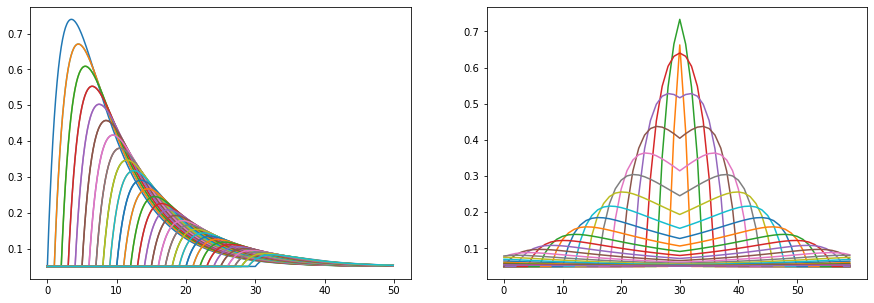

In [33]:
index = 9

data = data_mat[index]
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.plot(trange, data[:, data.shape[1] // 2, ::])

ax2 = fig.add_subplot(122)
ax2.plot(data[::20, data.shape[1] // 2, ::].T)
# ax2.set_ylim(0, 1)
ax2.set_xticks(range(0, len(yrange), 10))
ax2.set_xticklabels([int(y) for y in yrange[::10]])
plt.show()

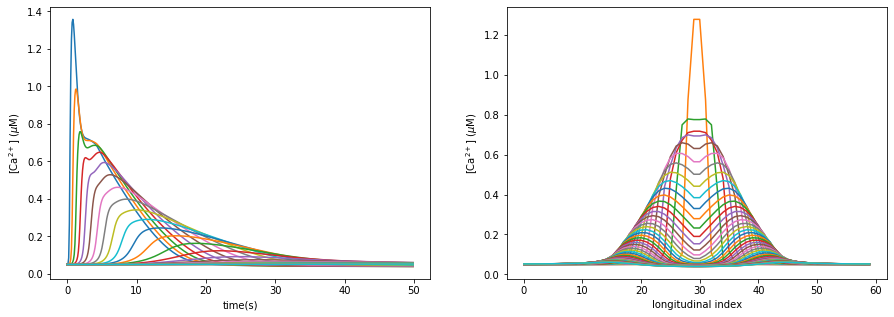

In [34]:
# Plot select data 
dt = 0.01
index = 9
calcium = calcium_data_list[index]

fig = plt.figure(figsize=(15,5))
# Calcium waves
ax11 = fig.add_subplot(121)
ax11.plot(np.arange(0, 50, dt*save_interval), calcium[:, numx // 2 , numy // 2 : ])
ax11.set_xlabel('time(s)')
ax11.set_ylabel(r'[Ca$^{2+}$] ($\mu$M)')
# Calcium wavefronts
ax12 = fig.add_subplot(122)
ax12.plot(calcium[:500, numx//2, :].T[:, ::10])
ax12.set_xlabel('longitudinal index')
ax12.set_ylabel(r'[Ca$^{2+}$] ($\mu$M)')
plt.show()

In [25]:
### Test parameter fitting performance

index = 2

calcium = calcium_data_list[index]
# Select traces
select_trace_1 = calcium[:, numx // 2, numy // 2]
select_trace_2 = calcium[:, numx // 2, numy // 2 + 8]
select_trace_2_x = calcium[:, numx // 2 + 2, numy // 2]
# Calculate the real targets
time_lag, amp_diff = calc_diffs(select_trace_2, select_trace_1, dt*save_interval, amp_metric='ratio', real_curve=True, amp_m_appt=amp_max_appt_list[index])
time_lag_x, amp_diff_x = calc_diffs(select_trace_2_x, select_trace_1, dt*save_interval, amp_metric='ratio', real_curve=True, amp_m_appt=amp_max_appt_list[index])
print(time_lag, amp_diff)
print(t_lag_best, a_diff_best)

12.0 0.14985798905010603
8.0 0.46926189795436524
